In [3]:
import pandas as pd
import numpy as np
# import pybedtools as bed
import subprocess 
import os 
import functools
# import align
import matplotlib.pyplot as plt 
import scipy.stats as stats
# import swalign
import skbio
import seqmap
import time
import seaborn as sns


In [4]:
def make_grid(df):
    m = max(df["length"])
    df["score_max"] = df["score"].apply(lambda x: np.max(x))
    mx = max(df["score_max"])
    mx_pad_length = 0.05
    df.drop(columns = ["score_max"])
    df["score_processed"] = df["score"].apply(lambda x: np.append(x, -mx))
    grid = df["score_processed"].apply(lambda x: np.pad(x, (0, m - (len(x)-1))))
    df = df.drop(columns = ["score_processed"])
    grid = np.stack(grid)
    return grid

# df = mapper.get()
# grid = make_grid(df)

# fig, ax = plt.subplots(figsize =(5,19))
# c = ax.pcolormesh(grid, cmap = "Blues")
# ax.set_yticks(range(len(df["id"])))
# ax.set_yticklabels(df["id"], )
# fig.colorbar(c, ax=ax)
# plt.grid(axis = "y")


In [5]:
xac = pd.read_table("xac_tss.csv", sep = "\t")
ids_table = pd.read_csv("all_gtf_merged_non_annotated_buffered.gtf.ids.csv", names = ["id", "transcript_id"])

# convert scores back to numpy arrays
xac["score"] = xac["score"].apply(lambda x: np.array(eval(x)))
# add transcript_ids
xac = xac.merge(ids_table, on ="id")

In [36]:
xac

id  \
0    >transcript::GL000252.2:2537541-2539571   
1    >transcript::GL000252.2:2752897-2754742   
2    >transcript::GL000252.2:2754331-2755843   
3    >transcript::GL000252.2:2757062-2759411   
4    >transcript::GL000252.2:2777491-2784986   
..                                       ...   
147  >transcript::GL000253.2:4626769-4634011   
148    >transcript::GL000254.2:161089-162381   
149    >transcript::GL000254.2:163352-164660   
150    >transcript::GL000254.2:168239-170952   
151    >transcript::GL000254.2:188464-190260   

                                                   seq  length  \
0    ATGTGGTGCATACCACCATGGAATAGTACACAGCCAGAAAAAGGAA...    2030   
1    TTGTGCCTCATGACCACCCCCTCCCTTGTCCCCACCATGCCCATGA...    1845   
2    TGGCATATTGTGTCCTGATTTGCCTCTCCTGTTAGAGCCATTGGAT...    1512   
3    CCAGGCTTCCTGATGGGGTCCCCAGTTAGGAGCTGCCTGCTCAGGG...    2349   
4    ATGCTCCCTCCCTTAATTCCCTGACCAGGGCCCTGGGACCCACCGC...    7495   
..                                                 ...     ...   
147  CGATGAAAGGGGCTGGAGAGAGCAGGAGGGAGGGGGCTGGGAAGAG...    7242   
148  ACTGACAAAACGGTAATGATCAGATGCCAAAACGAGTGTGAATGTG...    1292   
149  CCAGTCTCCCTCCAATACATGAGATTTGTATATTTTCTTTCGATTG...    1308   
150  AGGCAGGCCGGGCGCGGTTGCTCACGCCTGTAATCCCAGCACTTTA...    2713   
151  CTCAGAGTGGTTAAGTGACTTACTCCAGCAGCGAAAAGCTGTTCTT...    1796   

                                                 score transcript_id  
0    [187.0, 579.0, 831.0, 942.0, 1129.0, 1200.0, 1...   MSTRG.343.1  
1    [575.0, 928.0, 1361.0, 1585.0, 2082.0, 2425.0,...   MSTRG.344.1  
2    [439.0, 671.0, 1007.0, 1459.0, 1724.0, 2046.0,...   MSTRG.345.1  
3    [993.0, 1632.0, 2072.0, 3242.0, 3964.0, 4519.0...   MSTRG.346.1  
4    [114.0, 461.0, 1415.0, 2396.0, 2635.0, 2874.0,...   MSTRG.347.1  
..                                                 ...           ...  
147  [0.0, 175.0, 272.0, 338.0, 539.0, 703.0, 923.0...   MSTRG.548.1  
148  [429.0, 667.0, 982.0, 1220.0, 1440.0, 1539.0, ...   MSTRG.550.1  
149  [2823.0, 4336.0, 4969.0, 6199.0, 8612.0, 11176...   MSTRG.551.1  
150  [2070.0, 6632.0, 9484.0, 10762.0, 12236.0, 169...   MSTRG.552.1  
151  [661.0, 923.0, 1342.0, 1510.0, 1850.0, 2154.0,...   MSTRG.554.1  

[152 rows x 5 columns]

In [37]:
# let's load some big data...
tss = pd.read_table("../../data/pytss_results/tss.csv", sep = "\t", names = ["id", "seq", "length", "score"])
tss["score"] = tss["score"].apply(lambda x: np.array(eval(x)))
# add transcript_ids
tss = tss.merge(ids_table, on ="id")

/Users/NoahHK/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


<AxesSubplot:>

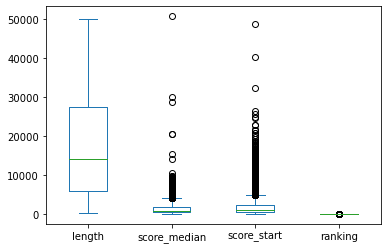

In [145]:
tss.plot.box()

-1.1995830180771805


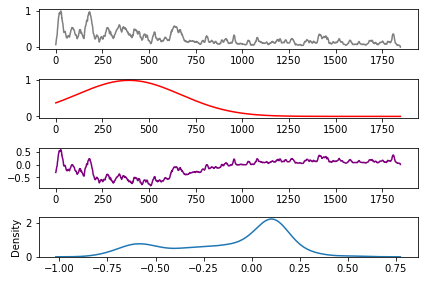

In [424]:
"""
We can experiment some more with finding a proper way to perform a statistical test to assess the tranking over something more profound than median fold change. 
But so far the approaches did not yield much. Since we cannot exactly work with specific distributions, we may want to use something like wilcoxon signed rank test, 
but there remains the question how to normalise the data before applying it ...


Idea: 
We use some randomized peaks througout the sequence length. This is the null-reference. Then we subtract this random null from the atual data. Our hope is now to find a significant difference when using a non-parametric test. 
"""

test_case = tss.iloc[4]

# long
# good: 9405, 1900, 1220
# bad: 9495, 945, 12400
# short
# bad: 10205

test_score = test_case.loc["score"]
test_length = test_case["length"]

xs = np.arange(test_length)

skew_factor = -.000286 * test_length
scale_factor = 300

skew_ys = stats.skewnorm.pdf(
                    xs
                    ,
                    a = skew_factor, loc = 500, scale = scale_factor
            )

norm_skew = skew_ys / np.max(skew_ys)

norm_ys = test_score * skew_ys

norm_scores = test_score / np.max(test_score)

random_null = np.random.random(test_length)

random_null = random_null * skew_ys
random_null = random_null /np.max(random_null)
random_diff = norm_scores - norm_skew

fig, ax = plt.subplots(4)
# ax[0].plot(
#     xs, test_score, color = "gray"
# )

ax[0].plot(
    xs, norm_scores, color = "gray"
)

# ax[1].plot(
#     xs, random_null, color = "blue", alpha  = 0.3
# )

ax[1].plot(
    xs, norm_skew, color = "red"
)

wilcx = stats.wilcoxon(random_diff, zero_method='pratt', correction=False, alternative='less', mode='auto')

ax[2].plot(
    xs, 
    random_diff
    ,
    color = "purple"
)

m, var = stats.norm.fit(random_diff)
print(np.log(var))

sns.kdeplot(random_diff, ax = ax[3])

plt.tight_layout()


In [345]:

test["max_score"] = test.score.apply(np.max)
test["norm_score"] = test.score / test.max_score
test["rd_null"] = test.length.apply(np.random.random)
test["rd_diff"] = test.norm_score - test.rd_null
test["wilcox"] = test.rd_diff.apply(lambda x: stats.wilcoxon(x, zero_method='pratt', correction=False, alternative='less', mode='auto'))
test

id  \
0        >transcript::chr22:12601786-12629425   
1       >transcript::chr4:142027532-142474934   
2       >transcript::chr2:188290907-188596431   
3       >transcript::chr2:191244903-191426246   
4       >transcript::chr2:191244903-191426246   
...                                       ...   
6995    >transcript::ML143370.1:287452-291016   
6996     >transcript::chr19:41883414-41907954   
6997    >transcript::chr2:100820616-100997329   
6998  >transcript::GL000253.2:1654876-1657648   
6999  >transcript::GL000251.2:2974894-2984296   

                                                    seq  length  \
0     GGCCCTTCACAAGCTTCACAGAGGTGGCTTCGGTCTTGAGCAAGGA...    1957   
1     AGCCCCCGGGCCTTGGAGATGAAGGCAGGCCCCTGCTCCACCCAGG...   48496   
2     CTTTCAAGTGTATGTTTCAGGGTGCCCAAGCAGACACTTGTTTTCT...   39784   
3     CCGTCTCCCTCTTTGTCGTCCCCTCCCCGCGCCCGGAGCGGGACTC...   44578   
4     CCGTCTCCCTCTTTGTCGTCCCCTCCCCGCGCCCGGAGCGGGACTC...   44578   
...                                                 ...     ...   
6995  CACAGGCAAGGCATGATGGGAAAGGTGCAGCCTGGGAGGCTCAGGG...    6885   
6996  ACCAGCTGGTATCGTGAGGAGGTGGGCACTCGGTTGCACAGTACAC...   28410   
6997  AAGCAAGATATCCTCATCTGGGACAAATGCCTGGAGGTTCAGATTT...    1348   
6998  TAGTAGGAGTAAACTGTGCTTTCTGAGGACCGGGAGTCCTTTTCCC...    2772   
6999  TTATATAGCTGAAACGTCTAAGAGAATTTGTGATCTGAGCGTTTCT...    9402   

                                                  score   transcript_id  \
0     [5873.0, 10774.0, 17171.0, 20978.0, 22919.0, 2...   MSTRG.23171.3   
1     [77.0, 230.0, 276.0, 414.0, 535.0, 682.0, 751....   MSTRG.26824.2   
2     [26.0, 26.0, 26.0, 51.0, 51.0, 51.0, 51.0, 71....   MSTRG.21399.2   
3     [278.0, 336.0, 467.0, 740.0, 1018.0, 1119.0, 1...   MSTRG.21440.6   
4     [278.0, 336.0, 467.0, 740.0, 1018.0, 1119.0, 1...   MSTRG.21440.4   
...                                                 ...             ...   
6995  [145.0, 339.0, 436.0, 543.0, 715.0, 841.0, 933...    MSTRG.2929.3   
6996  [41.0, 41.0, 61.0, 82.0, 102.0, 102.0, 102.0, ...   MSTRG.19105.8   
6997  [470.0, 1062.0, 1437.0, 1775.0, 1809.0, 2419.0...  MSTRG.20705.12   
6998  [198.0, 463.0, 549.0, 600.0, 863.0, 990.0, 121...     MSTRG.436.1   
6999  [20.0, 20.0, 38.0, 57.0, 57.0, 93.0, 210.0, 24...     MSTRG.189.1   

      score_median  score_start   ranking  range_rank  score_sum  \
0              0.0       1938.5       inf   2977210.0        0.0   
1             21.0       1527.0  6.184167   2977210.0       21.0   
2            211.0       6866.0  5.024155   1210551.0      211.0   
3            200.0       5323.5  4.734303   4439486.0      200.0   
4            200.0       5323.5  4.734303   8377571.0      200.0   
...            ...          ...       ...         ...        ...   
6995        1366.0       1851.0  0.438347   1133260.0     1366.0   
6996         477.5        647.0  0.438265         NaN      477.5   
6997        4111.0       5570.0  0.438188   1497491.0     4111.0   
6998        3125.0       4233.5  0.437995   4934637.0     3125.0   
6999        1121.5       1519.0  0.437692         NaN     1121.5   

                                                     xs   mean_score  \
0     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  3234.146142   
1     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   366.842688   
2     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   465.878896   
3     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   426.479766   
4     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   426.479766   
...                                                 ...          ...   
6995  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  1904.076834   
6996  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   654.015276   
6997  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  5594.649110   
6998  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  4643.752525   
6999  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  1702.923101   

      max_score                                         norm_score

In [352]:
test["pval"] = test.wilcox.apply(lambda x: x[1])
test["wilcox"] = test.wilcox.apply(lambda x: x[0])

TypeError: 'float' object is not subscriptable

<AxesSubplot:xlabel='length', ylabel='logwilcox'>

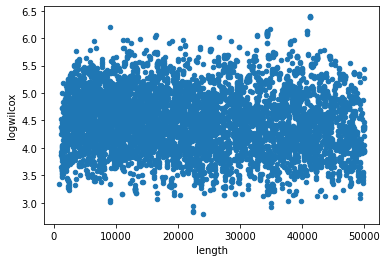

In [364]:
test.sort_values(["wilcox"], ascending = False)
test["normwilcox"] = test.wilcox / test.length
test["logwilcox"] = test.normwilcox.apply(np.log)
test.plot.scatter(
    x = "length", y = "logwilcox"
)

In [367]:
test = test.sort_values("logwilcox", ascending = False).reset_index(drop=True)

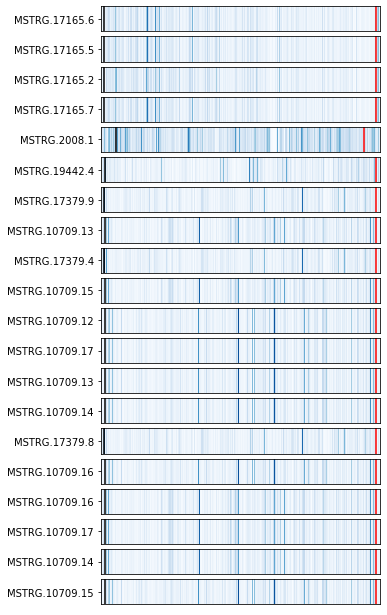

In [374]:
n = 20
offset = 0
fig, axs = plt.subplots(n, figsize =(5,11))

buffer = 500 # since we buffered symmetrically with 500bp


for idx in range(n):
    i = idx + offset
    scores = test["score"][i]
    id = test["transcript_id"][i]
    grid = np.expand_dims(scores, 0)  
    i = idx  
    ax = axs[i]

    c = ax.pcolorfast(grid, cmap = "Blues")
    ax.set_yticks(np.arange(1) + 0.5 )
    ax.set_yticklabels([id],)
    ax.set_xticks([])
    ax.vlines(ymin = 0, ymax = 1, x = buffer, color = "black")
    ax.vlines(ymin = 0, ymax = 1, x = np.shape(grid)[1] - buffer, color = "red")

# fig.colorbar(c)

/var/folders/1p/6pdz83894w5fnwm59tb6_3bh0000gp/T/ipykernel_57424/1296832883.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["score_sum"] = test["score"].apply(np.median)
/var/folders/1p/6pdz83894w5fnwm59tb6_3bh0000gp/T/ipykernel_57424/1296832883.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["score_start"] = test["score"].apply(lambda x: np.median(x[:100]))
/var/folders/1p/6pdz83894w5fnwm59tb6_3bh0000gp/T/ipykernel_57424/1296832883.py:14: SettingWithCopyWarning: 
A value is trying to be

Text(0.5, 1.0, 'rank = log2(median FC)')

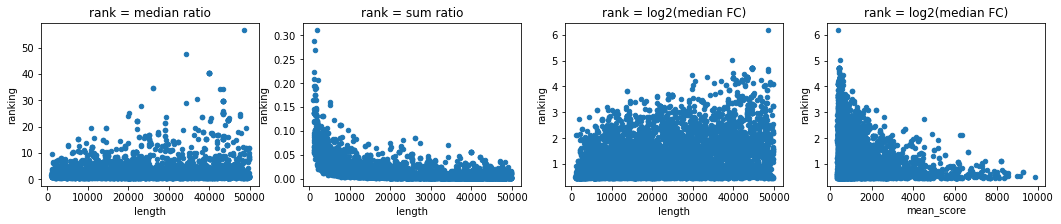

In [312]:
# now we define a method to classify the "goodness of annotation" based on the ratio of the sum of peaks in the start area 0 - 300 over the total sum of peaks
# from the plots below, we decide to go with log2 Median Fold Change between the starting position and the overall transcript

test = tss[:7000]

fig, axs = plt.subplots(1,4, figsize = (18, 3))

# ----------------------------------------------------------------
#   Median (Start) / Median (Overall) * note that columns were not renamed, hence names may be misleading here...
# ----------------------------------------------------------------

test["score_sum"] = test["score"].apply(np.median)
test["score_start"] = test["score"].apply(lambda x: np.median(x[:100]))
test["ranking"] = test["score_start"] / test["score_sum"]

test = test.sort_values("ranking", ascending = False).reset_index(drop=True)
test["xs"] = test["length"].apply(lambda x: np.arange(x))
test.plot.scatter(ax = axs[0], x = "length", y = "ranking")
axs[0].set_title("rank = median ratio")

# ----------------------------------------------------------------
#   Sum (Start) / Sum (Overall)
# ----------------------------------------------------------------

test["score_sum"] = test["score"].apply(np.sum)
test["score_start"] = test["score"].apply(lambda x: np.sum(x[:100]))
test["ranking"] = test["score_start"] / test["score_sum"]

test = test.sort_values("ranking", ascending = False).reset_index(drop=True)
test["xs"] = test["length"].apply(lambda x: np.arange(x))
test.plot.scatter(ax = axs[1], x = "length", y = "ranking")
axs[1].set_title("rank = sum ratio")

# ----------------------------------------------------------------
#   log2( Median (Start) / Median (Overall) )
# ----------------------------------------------------------------

test["score_sum"] = test["score"].apply(np.median)
test["score_start"] = test["score"].apply(lambda x: np.median(x[:500+100]))
test["ranking"] = test["score_start"] / test["score_sum"]
test["ranking"] = test.ranking.apply(np.log2)

test = test.sort_values("ranking", ascending = False).reset_index(drop=True)
test["xs"] = test["length"].apply(lambda x: np.arange(x))
test.plot.scatter(ax = axs[2], x = "length", y = "ranking")
axs[2].set_title("rank = log2(median FC)")

# also plot against mean over total sequence (this should decrease as higher mean score means less specificity toward 5' end)
test["mean_score"] = test.score.apply(np.mean)
test.plot.scatter(ax = axs[3], x = "mean_score", y = "ranking")
axs[3].set_title("rank = log2(median FC)")


/var/folders/1p/6pdz83894w5fnwm59tb6_3bh0000gp/T/ipykernel_57424/2909311195.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["_start"] = test["score"].apply(lambda x: x[:600])
/var/folders/1p/6pdz83894w5fnwm59tb6_3bh0000gp/T/ipykernel_57424/2909311195.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["_start_means"] = test["_start"].apply(np.mean)
/var/folders/1p/6pdz83894w5fnwm59tb6_3bh0000gp/T/ipykernel_57424/2909311195.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy 

id  \
0       >transcript::chr22:12601786-12629425   
1      >transcript::chr4:142027532-142474934   
2        >transcript::chr8:96238923-96262110   
3          >transcript::chr4:1870960-1982707   
4          >transcript::chr4:1870960-1982707   
...                                      ...   
6995    >transcript::chr19:41708120-41730994   
6996    >transcript::chr11:60931254-60937659   
6997   >transcript::GL000214.1:121316-123350   
6998  >transcript::chr11:119045109-119057652   
6999  >transcript::chr11:119045109-119057652   

                                                    seq  length  \
0     GGCCCTTCACAAGCTTCACAGAGGTGGCTTCGGTCTTGAGCAAGGA...    1957   
1     AGCCCCCGGGCCTTGGAGATGAAGGCAGGCCCCTGCTCCACCCAGG...   48496   
2     CCCTCTCCCCGCCTTGCCGTCCGCCGCTGACGTAACCTGCGAAGTT...   34332   
3     CAAAGCCGGCGGCCCGCGGGCGCGCGCTCGGTCCGCCCCCGCGCCC...   40009   
4     CAAAGCCGGCGGCCCGCGGGCGCGCGCTCGGTCCGCCCCCGCGCCC...   40009   
...                                                 ...     ...   
6995  CAGGCGTGAGCCACCCCGCCTGGCCTGAACTACTATCTTTTATTGT...   34526   
6996  GACTTTGCCACCATGACCTCCTTCCTGTTCCTCCATATATCTCGCT...   17059   
6997  AGAAGACACACATATGTTGAGAATAATCATTCTGGTCATTTGCTGC...    2034   
6998  AGATACAGGGGACTGACTCTATTTTCTTAGTTATACTTAAGCATTT...   44220   
6999  AGATACAGGGGACTGACTCTATTTTCTTAGTTATACTTAAGCATTT...   44220   

                                                  score   transcript_id  \
0     [5873.0, 10774.0, 17171.0, 20978.0, 22919.0, 2...   MSTRG.23171.3   
1     [77.0, 230.0, 276.0, 414.0, 535.0, 682.0, 751....   MSTRG.26824.2   
2     [3329.0, 4963.0, 5736.0, 6169.0, 7690.0, 8515....   MSTRG.32655.3   
3     [216.0, 368.0, 637.0, 1101.0, 1918.0, 2637.0, ...  MSTRG.25862.10   
4     [216.0, 368.0, 637.0, 1101.0, 1918.0, 2637.0, ...   MSTRG.25862.7   
...                                                 ...             ...   
6995  [151.0, 173.0, 197.0, 197.0, 219.0, 219.0, 219...   MSTRG.19100.3   
6996  [134.0, 155.0, 264.0, 286.0, 335.0, 383.0, 677...   MSTRG.8141.17   
6997  [720.0, 1139.0, 1261.0, 2108.0, 2442.0, 2939.0...      MSTRG.10.1   
6998  [0.0, 0.0, 0.0, 22.0, 64.0, 89.0, 156.0, 194.0...   MSTRG.9035.12   
6999  [0.0, 0.0, 0.0, 22.0, 64.0, 89.0, 156.0, 194.0...   MSTRG.9035.10   

      score_median  score_start    ranking  range_rank  good_start  ...  \
0              0.0      20696.5        inf       107.5        True  ...   
1             21.0       1190.5  56.690476      1349.5        True  ...   
2            253.5      12063.5  47.587771      1726.5        True  ...   
3            291.0      11776.0  40.467354      3617.0        True  ...   
4            291.0      11776.0  40.467354      3617.0        True  ...   
...            ...          ...        ...         ...         ...  ...   
6995         388.0        524.0   0.433510         NaN        True  ...   
6996         615.0        830.5   0.433394         NaN       False  ...   
6997        3196.0       4315.0   0.433093         NaN       False  ...   
6998         240.0        324.0   0.432959         NaN       False  ...   
6999         240.0        324.0   0.432959         NaN       False  ...   

      _start_means  _start_score_var  \
0      9585.011667      1.556980e+08   
1      2581.490000      5.880572e+06   
2      5058.781667      2.571964e+07   
3      6567.195000      2.448408e+07   
4      6567.195000      2.448408e+07   
...            ...               ...   
6995   1550.945000      8.315174e+06   
6996   1165.361667      9.021187e+05   
6997   5203.770000      1.344898e+07   
6998    341.280000      4.849877e+04   
6999    341.280000      4.849877e+04   

                                           _start_zrank _start_mean_zrank  \
0     [-2.3841103144628598e-05, 7.636504418159613e-0...     -2.891206e-21   
1     [-0.000425892266559742, -0.0003998743879562576...      4.625929e-20   
2     [-6.72552897199298e-05, -3.7240675315619307e-0...      5.782412e-21   
3     [-0.00025940099856910774, -0.00025319288312272...      1.156482

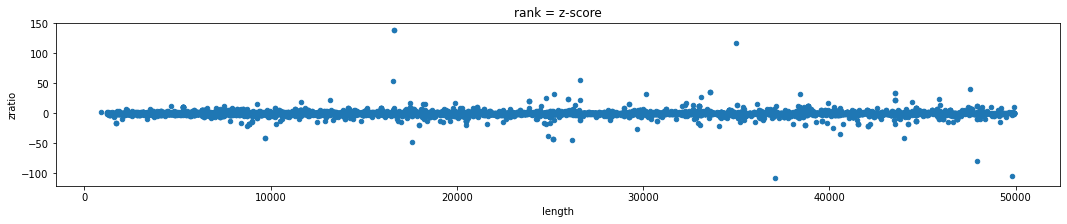

In [604]:

fig, axs = plt.subplots(1,1, figsize = (18, 3))

test = tss[:7000]

# ----------------------------------------------------------------
#   Z-score - try 
# ----------------------------------------------------------------
# make zscore for starting regaion
test["_start"] = test["score"].apply(lambda x: x[:600])
test["_start_means"] = test["_start"].apply(np.mean)
test["_start_score_var"] = test["_start"].apply(np.var)
test["_start_zrank"] = (test["_start"] - test["_start_means"]) / test["_start_score_var"]
test["_start_mean_zrank"] = test["_start_zrank"].apply(np.mean)

# make zscore overall
test["score_means"] = test["score"].apply(np.mean)
test["score_var"] = test["score"].apply(np.var)
test["zrank"] = (test["score"] - test["score_means"]) / test["score_var"]
test["mean_zrank"] = test["zrank"].apply(np.mean)

# zratio
test["zratio"] = test["_start_mean_zrank"] / test["mean_zrank"]

# test = test.sort_values("zrank", ascending = False).reset_index(drop=True)
test["xs"] = test["length"].apply(lambda x: np.arange(x))
test.plot.scatter(ax = axs, x = "length", y = "zratio")
axs.set_title("rank = z-score")

test

In [534]:
test

id  \
3316  >transcript::chr12:122270968-122424206   
3693   >transcript::chr4:174283229-174320831   
4267   >transcript::chr2:101006860-101151951   
2089     >transcript::chr3:47850192-48089463   
818      >transcript::KI270797.1:48020-51769   
...                                      ...   
6465   >transcript::KI270861.1:182178-184714   
6509     >transcript::chrX:48965589-49002764   
6758    >transcript::chr17:68180194-68189046   
6759   >transcript::chr3:100334188-100353147   
6901     >transcript::chrX:40050817-40098491   

                                                    seq  length  \
3316  AACACTCTGCACCCCTTCTCTTAGTAGTAATAGGTTTTTCACTCCT...   18900   
3693  GTAAAACTCCACCCCTTTTTACTCATAACCTCTGCCTGGGCTCACT...    4963   
4267  TGCATCATTTTTATTTATTTATTTATTTAAGACGGAGTCTCGCTCT...   15618   
2089  CCCGCTGCTCTGTACAGGAGGCTGCAGGGGAAGGGAAGACACCATG...   18256   
818   TCCCGCCTTTGTTCTCGGGTCGCCCCTCTCGCTGGTGGCGCTCCGA...    1816   
...                                                 ...     ...   
6465  TAAAAAATACAAAAATTAGCCGGGCGTGGTGGCGCGCTCCTGACGT...   12602   
6509  TGTGTTCCTAGGTGACACAGTCATTACTTATAAATGTTCCTGGCCG...   12896   
6758  TAGCCAGAAACCCCCGCCGAGTACTTTGGGTGTCATAATAGGAAAA...   13043   
6759  TCTATTTTTAACTTTTCATACTATAATGTTAAACAAAACTAAATTA...    9104   
6901  ACAGTCAATAATAATGTATATTTCAAAATGAATAAGAGTAAATTTG...   19954   

                                                  score   transcript_id  \
3316  [78.0, 187.0, 355.0, 440.0, 590.0, 610.0, 748....  MSTRG.10829.13   
3693  [142.0, 235.0, 416.0, 586.0, 835.0, 1224.0, 23...   MSTRG.27066.1   
4267  [43.0, 83.0, 101.0, 169.0, 216.0, 246.0, 286.0...   MSTRG.20709.3   
2089  [421.0, 598.0, 679.0, 836.0, 938.0, 985.0, 115...   MSTRG.24383.5   
818   [1449.0, 2690.0, 3865.0, 4331.0, 5484.0, 6078....    MSTRG.1537.2   
...                                                 ...             ...   
6465  [61.0, 120.0, 162.0, 162.0, 219.0, 219.0, 238....    MSTRG.1970.1   
6509  [38.0, 63.0, 63.0, 102.0, 191.0, 191.0, 213.0,...   MSTRG.34852.3   
6758  [20.0, 197.0, 293.0, 521.0, 656.0, 716.0, 835....   MSTRG.17066.1   
6759  [94.0, 94.0, 228.0, 249.0, 331.0, 392.0, 455.0...   MSTRG.24763.1   
6901  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0,...  MSTRG.34751.15   

      score_median  score_start   ranking  range_rank  good_start  ...  \
3316         574.0        917.5  1.598432      1064.0        True  ...   
3693        1464.0       2177.5  1.487363      2771.5        True  ...   
4267         675.0        881.0  1.305185      1903.5        True  ...   
2089         621.0       1383.5  2.227858       700.5        True  ...   
818         3720.5      15703.0  4.220669      6150.0        True  ...   
...            ...          ...       ...         ...         ...  ...   
6465        1086.0        752.0  0.692449      2277.5       False  ...   
6509         918.0        616.5  0.671569      1736.5       False  ...   
6758         726.0        427.5  0.588843      2056.0       False  ...   
6759         825.0        485.5  0.588485      2183.0       False  ...   
6901         445.0        223.0  0.501124      1691.0       False  ...   

      _start_means  _start_score_var  \
3316   1207.421667      1.214221e+06   
3693   3709.533333      1.162983e+07   
4267   2377.186667      1.130231e+07   
2089   1065.830000      3.401525e+05   
818   10422.576667      7.298833e+07   
...            ...               ...   
6465   2860.243333      7.249248e+06   
6509   5223.031667      3.911833e+07   
6758   3392.060000      2.605163e+07   
6759   4837.396667      2.946137e+07   
6901   3184.793333      2.069562e+07   

                                           _start_zrank _start_mean_zrank  \
3316  [-0.0009301614814456337, -0.000840391996345524...      1.156482e-20   
3693  [-0.0003067571803931336, -0.000298760501704807...      2.891206e-21   
4267  [-0.00020652289161534327, -0.00020298379348639...      2.891206e-20   
2089  [-0.001895708332014068, -0.0013753535489449023...      2.312965e-19   
818 

In [558]:
test["zratio"] = test["zratio"].apply(lambda x: 10 if x == 100 else x)
test["zratio"] = test["zratio"].apply(lambda x: 0.001 if x == 0 else x)
test["zratio"] = test["zratio"].apply(lambda x: 0.001 if x != x else x)

test

id  \
3316  >transcript::chr12:122270968-122424206   
3693   >transcript::chr4:174283229-174320831   
4267   >transcript::chr2:101006860-101151951   
2089     >transcript::chr3:47850192-48089463   
818      >transcript::KI270797.1:48020-51769   
...                                      ...   
6465   >transcript::KI270861.1:182178-184714   
6509     >transcript::chrX:48965589-49002764   
6758    >transcript::chr17:68180194-68189046   
6759   >transcript::chr3:100334188-100353147   
6901     >transcript::chrX:40050817-40098491   

                                                    seq  length  \
3316  AACACTCTGCACCCCTTCTCTTAGTAGTAATAGGTTTTTCACTCCT...   18900   
3693  GTAAAACTCCACCCCTTTTTACTCATAACCTCTGCCTGGGCTCACT...    4963   
4267  TGCATCATTTTTATTTATTTATTTATTTAAGACGGAGTCTCGCTCT...   15618   
2089  CCCGCTGCTCTGTACAGGAGGCTGCAGGGGAAGGGAAGACACCATG...   18256   
818   TCCCGCCTTTGTTCTCGGGTCGCCCCTCTCGCTGGTGGCGCTCCGA...    1816   
...                                                 ...     ...   
6465  TAAAAAATACAAAAATTAGCCGGGCGTGGTGGCGCGCTCCTGACGT...   12602   
6509  TGTGTTCCTAGGTGACACAGTCATTACTTATAAATGTTCCTGGCCG...   12896   
6758  TAGCCAGAAACCCCCGCCGAGTACTTTGGGTGTCATAATAGGAAAA...   13043   
6759  TCTATTTTTAACTTTTCATACTATAATGTTAAACAAAACTAAATTA...    9104   
6901  ACAGTCAATAATAATGTATATTTCAAAATGAATAAGAGTAAATTTG...   19954   

                                                  score   transcript_id  \
3316  [78.0, 187.0, 355.0, 440.0, 590.0, 610.0, 748....  MSTRG.10829.13   
3693  [142.0, 235.0, 416.0, 586.0, 835.0, 1224.0, 23...   MSTRG.27066.1   
4267  [43.0, 83.0, 101.0, 169.0, 216.0, 246.0, 286.0...   MSTRG.20709.3   
2089  [421.0, 598.0, 679.0, 836.0, 938.0, 985.0, 115...   MSTRG.24383.5   
818   [1449.0, 2690.0, 3865.0, 4331.0, 5484.0, 6078....    MSTRG.1537.2   
...                                                 ...             ...   
6465  [61.0, 120.0, 162.0, 162.0, 219.0, 219.0, 238....    MSTRG.1970.1   
6509  [38.0, 63.0, 63.0, 102.0, 191.0, 191.0, 213.0,...   MSTRG.34852.3   
6758  [20.0, 197.0, 293.0, 521.0, 656.0, 716.0, 835....   MSTRG.17066.1   
6759  [94.0, 94.0, 228.0, 249.0, 331.0, 392.0, 455.0...   MSTRG.24763.1   
6901  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0,...  MSTRG.34751.15   

      score_median  score_start   ranking  range_rank  good_start  ...  \
3316         574.0        917.5  1.598432      1064.0        True  ...   
3693        1464.0       2177.5  1.487363      2771.5        True  ...   
4267         675.0        881.0  1.305185      1903.5        True  ...   
2089         621.0       1383.5  2.227858       700.5        True  ...   
818         3720.5      15703.0  4.220669      6150.0        True  ...   
...            ...          ...       ...         ...         ...  ...   
6465        1086.0        752.0  0.692449      2277.5       False  ...   
6509         918.0        616.5  0.671569      1736.5       False  ...   
6758         726.0        427.5  0.588843      2056.0       False  ...   
6759         825.0        485.5  0.588485      2183.0       False  ...   
6901         445.0        223.0  0.501124      1691.0       False  ...   

      _start_means  _start_score_var  \
3316   1207.421667      1.214221e+06   
3693   3709.533333      1.162983e+07   
4267   2377.186667      1.130231e+07   
2089   1065.830000      3.401525e+05   
818   10422.576667      7.298833e+07   
...            ...               ...   
6465   2860.243333      7.249248e+06   
6509   5223.031667      3.911833e+07   
6758   3392.060000      2.605163e+07   
6759   4837.396667      2.946137e+07   
6901   3184.793333      2.069562e+07   

                                           _start_zrank _start_mean_zrank  \
3316  [-0.0009301614814456337, -0.000840391996345524...      1.156482e-20   
3693  [-0.0003067571803931336, -0.000298760501704807...      2.891206e-21   
4267  [-0.00020652289161534327, -0.00020298379348639...      2.891206e-20   
2089  [-0.001895708332014068, -0.0013753535489449023...      2.312965e-19   
818 

In [522]:
test1 = test.query("zratio < 0.5").reset_index(drop = True).query("zratio > -0.5").reset_index(drop = True)
test1


id  \
0           >transcript::chr5:863240-893309   
1           >transcript::chr5:863240-893309   
2           >transcript::chr5:863240-893309   
3       >transcript::chr7:76067898-76170836   
4       >transcript::chr7:76067898-76170836   
...                                     ...   
2694   >transcript::chr22:21472575-21518033   
2695   >transcript::chr22:21472575-21518033   
2696  >transcript::chr8:143368315-143384721   
2697  >transcript::chr8:143368315-143384721   
2698  >transcript::chr8:143368315-143384721   

                                                    seq  length  \
0     GCAATCCTCCCGCCTCAGCCCACGGAGTAGATGGGACCACAGGAGC...   44358   
1     GCAATCCTCCCGCCTCAGCCCACGGAGTAGATGGGACCACAGGAGC...   44358   
2     GCAATCCTCCCGCCTCAGCCCACGGAGTAGATGGGACCACAGGAGC...   44358   
3     CACCTATCATAGCTGATACACAGAGCTATGAGCAAGCAGGTCGGAG...   10787   
4     CACCTATCATAGCTGATACACAGAGCTATGAGCAAGCAGGTCGGAG...   10787   
...                                                 ...     ...   
2694  GGAGGCCATAAAGTGAAGGAAGGGATGACCAAGAGGAAGATGGCCA...   47839   
2695  GGAGGCCATAAAGTGAAGGAAGGGATGACCAAGAGGAAGATGGCCA...   47839   
2696  GACCGAGCTGCTGGGGACTGGGCCTTGCGGGGCGGGGCCGCTGGGG...   16775   
2697  GACCGAGCTGCTGGGGACTGGGCCTTGCGGGGCGGGGCCGCTGGGG...   16775   
2698  GACCGAGCTGCTGGGGACTGGGCCTTGCGGGGCGGGGCCGCTGGGG...   16775   

                                                  score   transcript_id  \
0     [21.0, 41.0, 66.0, 92.0, 168.0, 250.0, 301.0, ...  MSTRG.27172.15   
1     [21.0, 41.0, 66.0, 92.0, 168.0, 250.0, 301.0, ...  MSTRG.27172.16   
2     [21.0, 41.0, 66.0, 92.0, 168.0, 250.0, 301.0, ...  MSTRG.27172.17   
3     [17.0, 74.0, 176.0, 193.0, 211.0, 211.0, 260.0...   MSTRG.31040.5   
4     [17.0, 74.0, 176.0, 193.0, 211.0, 211.0, 260.0...   MSTRG.31040.4   
...                                                 ...             ...   
2694  [21.0, 47.0, 47.0, 47.0, 47.0, 47.0, 47.0, 66....  MSTRG.23305.11   
2695  [21.0, 47.0, 47.0, 47.0, 47.0, 47.0, 47.0, 66....  MSTRG.23305.10   
2696  [105.0, 162.0, 336.0, 431.0, 535.0, 603.0, 767...   MSTRG.33045.2   
2697  [105.0, 162.0, 336.0, 431.0, 535.0, 603.0, 767...   MSTRG.33045.3   
2698  [105.0, 162.0, 336.0, 431.0, 535.0, 603.0, 767...   MSTRG.33045.4   

      score_median  score_start   ranking  range_rank  good_start  ...  \
0            303.0        318.0  1.049505      1540.0        True  ...   
1            303.0        318.0  1.049505      1540.0        True  ...   
2            303.0        318.0  1.049505      1540.0        True  ...   
3           1079.0        900.5  0.834569      2291.5       False  ...   
4           1079.0        900.5  0.834569      2291.5       False  ...   
...            ...          ...       ...         ...         ...  ...   
2694         318.0        440.5  1.385220       871.0        True  ...   
2695         318.0        440.5  1.385220       871.0        True  ...   
2696         813.0       2701.0  3.322263      2515.0        True  ...   
2697         813.0       2701.0  3.322263      2515.0        True  ...   
2698         813.0       2701.0  3.322263      2515.0        True  ...   

     _start_means  _start_score_var  \
0     1563.841667      2.565371e+06   
1     1563.841667      2.565371e+06   
2     1563.841667      2.565371e+06   
3     4731.861667      1.998988e+07   
4     4731.861667      1.998988e+07   
...           ...               ...   
2694  3226.795000      1.671350e+07   
2695  3226.795000      1.671350e+07   
2696  2811.140000      3.017095e+06   
2697  2811.140000      3.017095e+06   
2698  2811.140000      3.017095e+06   

                                           _start_zrank _start_mean_zrank  \
0     [-0.0006014107334495544, -0.000593614590184265...     -2.312965e-20   
1     [-0.0006014107334495544, -0.000593614590184265...     -2.312965e-20   
2     [-0.0006014107334495544, -0.000593614590184265...     -2.312965e-20   
3     [-0.0002358624433798621, -0.000233011000384683...     -5.782412e-21   
4     [-0.00023586244337986

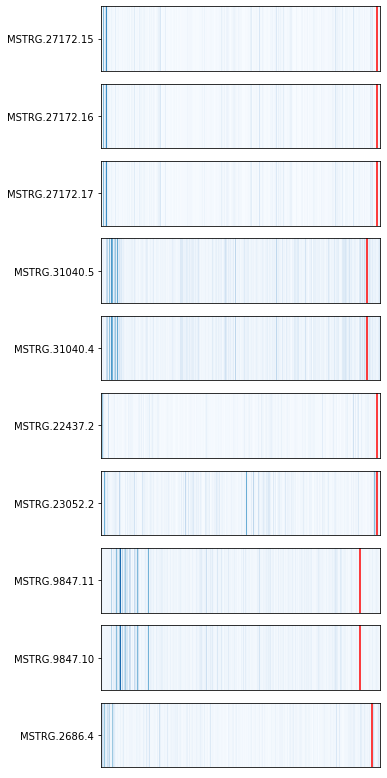

In [524]:
test = test.sort_values("zratio", ascending = False)

n = 10
offset = 0
fig, axs = plt.subplots(n, figsize =(5,14))

buffer = 500 # since we buffered symmetrically with 500bp


for idx in range(n):
    i = idx + offset
    scores = test1["score"][i]
    id = test1["transcript_id"][i]
    grid = np.expand_dims(scores, 0)  
    i = idx  
    ax = axs[i]

    c = ax.pcolorfast(grid, cmap = "Blues")
    ax.set_yticks(np.arange(1) + 0.5 )
    ax.set_yticklabels([id],)
    ax.set_xticks([])
    # ax.vlines(ymin = 0, ymax = 1, x = buffer, color = "black")
    ax.vlines(ymin = 0, ymax = 1, x = np.shape(grid)[1] - buffer, color = "red")

# fig.colorbar(c)

In [306]:
# ----------------------------------------------------------------
#   Apply log2(MedFC)
# ----------------------------------------------------------------
buffer_into_transcript = 100

tss["score_median"] = tss["score"].apply(np.median)
tss["score_start"] = tss["score"].apply(lambda x: np.median(x[:500+buffer_into_transcript]))
tss["ranking"] = tss["score_start"] / tss["score_median"]
tss["ranking"] = tss.ranking.apply(np.log2)

tss[["id", "ranking"]].to_csv("tss_rankings.csv", index = False)

In [317]:
"""
At the most basic level we can assign ranks based on the sum (or median) without normalising of peaks from 0 to 1000, thereby assigning the TSS an effective window from -500 to +500 around the sequence start. 
"""

tss["range_rank"] = test["score"].apply(lambda x: np.median(x[:1000]))

In [426]:
# sort by ranking
tss = tss.sort_values(["ranking"], ascending = False).reset_index(drop=True)

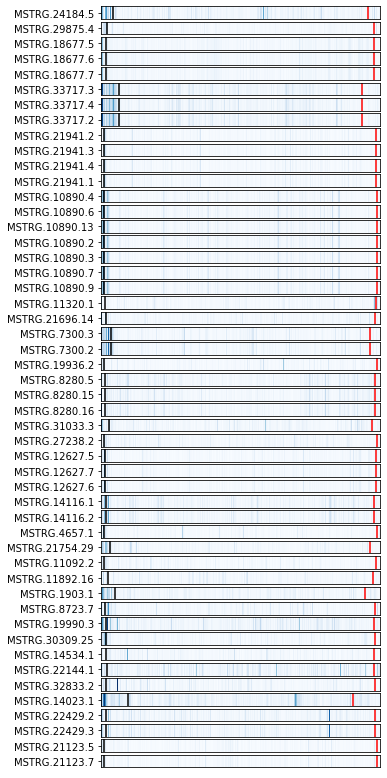

In [428]:
n = 50
offset = 100
fig, axs = plt.subplots(n, figsize =(5,14))

buffer = 500 # since we buffered symmetrically with 500bp


for idx in range(n):
    i = idx + offset
    scores = tss["score"][i]
    id = tss["transcript_id"][i]
    grid = np.expand_dims(scores, 0)  
    i = idx  
    ax = axs[i]

    c = ax.pcolorfast(grid, cmap = "Blues")
    ax.set_yticks(np.arange(1) + 0.5 )
    ax.set_yticklabels([id],)
    ax.set_xticks([])
    ax.vlines(ymin = 0, ymax = 1, x = buffer, color = "black")
    ax.vlines(ymin = 0, ymax = 1, x = np.shape(grid)[1] - buffer, color = "red")

# fig.colorbar(c)

In [442]:
subseet = tss.query("ranking < 1").reset_index()

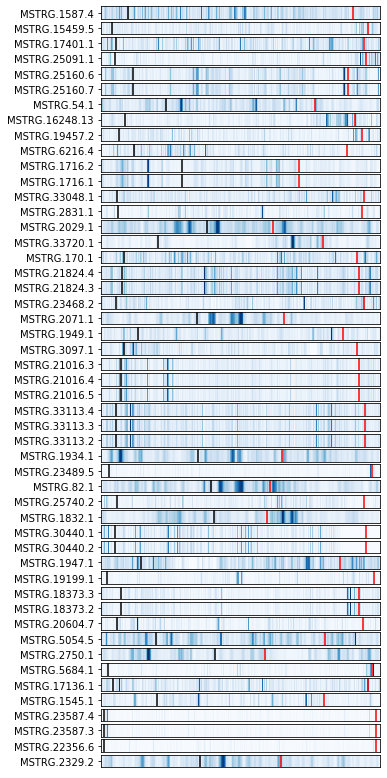

In [478]:
n = 50
offset = 12000
fig, axs = plt.subplots(n, figsize =(5,14))

buffer = 500 # since we buffered symmetrically with 500bp


for idx in range(n):
    i = idx + offset
    scores = tss["score"][i]
    id = tss["transcript_id"][i]
    grid = np.expand_dims(scores, 0)  
    i = idx  
    ax = axs[i]

    c = ax.pcolorfast(grid, cmap = "Blues")
    ax.set_yticks(np.arange(1) + 0.5 )
    ax.set_yticklabels([id],)
    ax.set_xticks([])
    ax.vlines(ymin = 0, ymax = 1, x = buffer, color = "black")
    ax.vlines(ymin = 0, ymax = 1, x = np.shape(grid)[1] - buffer, color = "red")

# fig.colorbar(c)

In [ ]:

test["good_start"] = test["score_start"] > test["score_median"]

# ALRIGHT, we classify the goodness based on wether or not their median within some start range is higher than the overall median.. then its good otherwise it isnt so good.


In [473]:
tss["good_start"] = tss["score_start"] > tss["score_median"]

In [651]:
to_plot = """714.1
8291.12
346731.1
14638.7
33074.3
9942.7
2775.3
31286.1
16095.2
23489.5
1587.4""".split("\n")
to_plot = [f"MSTRG.{i}" for i in to_plot]


index                                       id  \
0    1264    >transcript::chr7:100873887-100889164   
1    1291     >transcript::chr17:28335077-28347509   
2    2102     >transcript::chr16:28710963-28773327   
3    2485     >transcript::chr11:65498552-65507016   
4    3734    >transcript::KI270816.1:102156-107286   
5    5328     >transcript::chr16:28710963-28773327   
6    5331    >transcript::chr8:143989582-143993915   
7    5347     >transcript::chr12:52036753-52060007   
8    5390     >transcript::chr16:28710963-28773327   
9    5449  >transcript::GL000255.2:1315875-1318057   
10   5471     >transcript::chr11:65498552-65507016   
11   6605    >transcript::KZ208920.1:438456-443351   
12  11502    >transcript::KI270816.1:102156-107286   
13  12000    >transcript::KI270816.1:102156-107286   
14  12030     >transcript::chr22:30486402-30506371   
15  16593    >transcript::chr8:143989582-143993915   
16  17732    >transcript::chr7:100873887-100889164   

                                                  seq  length  \
0   ACATCGGGGATCCCAGTGAGAAGCCAGGGGGCAGAGGGACTGCTGG...   13400   
1   AATTCTCTGCTTGCCCTTTTCAAAGCCACTTCAGCTTATAAACTCC...   22581   
2   GAGACGGGGTTTCGCTGTGTTGGCCGGGCCGGTCTCCAGCTCCTAA...   27427   
3   CGGGAGGCTGAGGCAGGAGAATCACTGGAACCTGGGAGGCGGAGGT...    8070   
4   CCCCCTGCATTTCCCTGTGCAAGGGGAGAAGGAGCAGTAGGAGACC...    3086   
5   CCATGTTGGCCAGGCTGGTTTTGAACTCCTGACCTCAGGTGATCCG...    4647   
6   CTGATCCCATCAACCCGAAGGCCCACGCGTCACCCCCAGAACCCCG...    4491   
7   AGGCTCCAGGTACCAACAGCTCTCCACAGGAGCAGGTCTGAGGCCG...    3262   
8   GCTAATTTTTGTGTTTTTAGTAGAGACGGCTTCGCCATGTTGGCCA...    4681   
9   AGTTCAGCACCGCCGTGTCCCGGCCGGGTCGCGGGGAGCCCCGGTA...    3627   
10  AGAGTTGCAACGGAAGATGGGCTACATACAAAGCGGGATGTAATCC...    7654   
11  TGCCGGTGTTGCTACAGGTGCGCAGGATGTCGGCAGAGCCAGAGGC...    2260   
12  TCTCCATGGGATAAGGCCAGGTGGGGGACCCACGCCCAAGCCTGAG...    5130   
13  CTGTCCAGCAGGCACCTGTCCCTCTCCATGGGATAAGGCCAGGTGG...    5152   
14  TCCTATGTCTGATGCATGGCCAATTGCATAATACTAATACACTCCC...   17137   
15  CCAGATGGAATCCCCGGAGTGTGATGGGCATGGGGCCGAGACATGG...   39781   
16  TGTCTCCTGACATCGATCTCTTCCTGTATCTTTGCTCTATAATTGC...   17543   

                                                score  transcript_id  \
0   [38.0, 88.0, 88.0, 192.0, 305.0, 347.0, 393.0,...  MSTRG.31286.1   
1   [105.0, 218.0, 340.0, 445.0, 576.0, 656.0, 824...  MSTRG.16095.2   
2   [46.0, 86.0, 86.0, 130.0, 300.0, 323.0, 378.0,...  MSTRG.14638.7   
3   [570.0, 1137.0, 1333.0, 1453.0, 1572.0, 1841.0...  MSTRG.8291.12   
4   [693.0, 1187.0, 1858.0, 2320.0, 3357.0, 3848.0...   MSTRG.1587.4   
5   [279.0, 437.0, 498.0, 536.0, 695.0, 861.0, 114...  MSTRG.14638.7   
6   [275.0, 346.0, 438.0, 510.0, 754.0, 792.0, 900...  MSTRG.33074.3   
7   [304.0, 704.0, 989.0, 1232.0, 1356.0, 1457.0, ...   MSTRG.9942.7   
8   [123.0, 280.0, 404.0, 467.0, 693.0, 885.0, 103...  MSTRG.14638.7   
9   [471.0, 643.0, 1066.0, 1533.0, 2265.0, 2575.0,...    MSTRG.714.1   
10  [60.0, 95.0, 166.0, 237.0, 294.0, 311.0, 383.0...  MSTRG.8291.12   
11  [533.0, 919.0, 1313.0, 1548.0, 2066.0, 2291.0,...   MSTRG.2775.3   
12  [227.0, 319.0, 337.0, 356.0, 411.0, 411.0, 510...   MSTRG.1587.4   
13  [174.0, 282.0, 521.0, 755.0, 954.0, 1117.0, 13...   MSTRG.1587.4   
14  [62.0, 81.0, 127.0, 193.0, 256.0, 256.0, 256.0...  MSTRG.23489.5   
15  [41.0, 63.0, 63.0, 63.0, 81.0, 81.0, 129.0, 15...  MSTRG.33074.3   
16  [63.0, 84.0, 145.0, 234.0, 296.0, 296.0, 315.0...  MSTRG.31286.1   

    score_median  score_start   ranking  range_rank  good_start   start_mean  \
0          770.0       2361.0  3.066234      1578.5        True  3283.951667   
1          409.0       1242.5  3.037897      1808.5        True  4022.986667   
2          439.0        974.0  2.218679      1049.0        True  1677.885000   
3         1255.5       2500.5  1.991637      2280.0       False  2239.895000   
4         3569.0       5242.5  1.468899      4646.5       False  5821.120000   
5         2472.0       2467.0  0.997977      3709.5        True  4759.356667   
6  

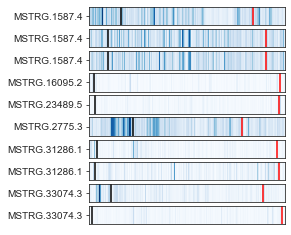

In [695]:
n = 10
offset = 0
fig, axs = plt.subplots(n, figsize =(3.5,4))

buffer = 500 # since we buffered symmetrically with 500bp
subset = tss.query(f"transcript_id in {to_plot}").reset_index()
subset = tss.query(f"transcript_id in {final_subset}").reset_index()
subset = subset.sort_values("transcript_id").reset_index()


for idx in range(n):
    i = idx + offset
    scores = subset["score"][i]
    id = subset["transcript_id"][i]
    grid = np.expand_dims(scores, 0)  
    i = idx  
    ax = axs[i]

    c = ax.pcolorfast(grid, cmap = "Blues")
    ax.set_yticks(np.arange(1) + 0.5 )
    ax.set_yticklabels([id],)
    ax.set_xticks([])
    ax.vlines(ymin = 0, ymax = 1, x = buffer, color = "black")
    ax.vlines(ymin = 0, ymax = 1, x = np.shape(grid)[1] - buffer, color = "red")

fig.savefig("../Plots/tss_maps.jpg", dpi = 1000, bbox_inches = "tight")

# fig.colorbar(c)

In [495]:
polyA = pd.read_table("../../data/pytss_results/polya.csv", sep = "\t", names = ["id", "seq", "length", "score"])


In [497]:
polyA["score"] = polyA["score"].apply(lambda x: np.array(eval(x)))
# add transcript_ids
polyA = polyA.merge(ids_table, on ="id")

In [565]:
test

id  \
3316  >transcript::chr12:122270968-122424206   
3693   >transcript::chr4:174283229-174320831   
4267   >transcript::chr2:101006860-101151951   
2089     >transcript::chr3:47850192-48089463   
818      >transcript::KI270797.1:48020-51769   
...                                      ...   
6465   >transcript::KI270861.1:182178-184714   
6509     >transcript::chrX:48965589-49002764   
6758    >transcript::chr17:68180194-68189046   
6759   >transcript::chr3:100334188-100353147   
6901     >transcript::chrX:40050817-40098491   

                                                    seq  length  \
3316  AACACTCTGCACCCCTTCTCTTAGTAGTAATAGGTTTTTCACTCCT...   18900   
3693  GTAAAACTCCACCCCTTTTTACTCATAACCTCTGCCTGGGCTCACT...    4963   
4267  TGCATCATTTTTATTTATTTATTTATTTAAGACGGAGTCTCGCTCT...   15618   
2089  CCCGCTGCTCTGTACAGGAGGCTGCAGGGGAAGGGAAGACACCATG...   18256   
818   TCCCGCCTTTGTTCTCGGGTCGCCCCTCTCGCTGGTGGCGCTCCGA...    1816   
...                                                 ...     ...   
6465  TAAAAAATACAAAAATTAGCCGGGCGTGGTGGCGCGCTCCTGACGT...   12602   
6509  TGTGTTCCTAGGTGACACAGTCATTACTTATAAATGTTCCTGGCCG...   12896   
6758  TAGCCAGAAACCCCCGCCGAGTACTTTGGGTGTCATAATAGGAAAA...   13043   
6759  TCTATTTTTAACTTTTCATACTATAATGTTAAACAAAACTAAATTA...    9104   
6901  ACAGTCAATAATAATGTATATTTCAAAATGAATAAGAGTAAATTTG...   19954   

                                                  score   transcript_id  \
3316  [78.0, 187.0, 355.0, 440.0, 590.0, 610.0, 748....  MSTRG.10829.13   
3693  [142.0, 235.0, 416.0, 586.0, 835.0, 1224.0, 23...   MSTRG.27066.1   
4267  [43.0, 83.0, 101.0, 169.0, 216.0, 246.0, 286.0...   MSTRG.20709.3   
2089  [421.0, 598.0, 679.0, 836.0, 938.0, 985.0, 115...   MSTRG.24383.5   
818   [1449.0, 2690.0, 3865.0, 4331.0, 5484.0, 6078....    MSTRG.1537.2   
...                                                 ...             ...   
6465  [61.0, 120.0, 162.0, 162.0, 219.0, 219.0, 238....    MSTRG.1970.1   
6509  [38.0, 63.0, 63.0, 102.0, 191.0, 191.0, 213.0,...   MSTRG.34852.3   
6758  [20.0, 197.0, 293.0, 521.0, 656.0, 716.0, 835....   MSTRG.17066.1   
6759  [94.0, 94.0, 228.0, 249.0, 331.0, 392.0, 455.0...   MSTRG.24763.1   
6901  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.0,...  MSTRG.34751.15   

      score_median  score_start   ranking  range_rank  good_start  ...  \
3316         574.0        917.5  1.598432      1064.0        True  ...   
3693        1464.0       2177.5  1.487363      2771.5        True  ...   
4267         675.0        881.0  1.305185      1903.5        True  ...   
2089         621.0       1383.5  2.227858       700.5        True  ...   
818         3720.5      15703.0  4.220669      6150.0        True  ...   
...            ...          ...       ...         ...         ...  ...   
6465        1086.0        752.0  0.692449      2277.5       False  ...   
6509         918.0        616.5  0.671569      1736.5       False  ...   
6758         726.0        427.5  0.588843      2056.0       False  ...   
6759         825.0        485.5  0.588485      2183.0       False  ...   
6901         445.0        223.0  0.501124      1691.0       False  ...   

      _start_means  _start_score_var  \
3316   1207.421667      1.214221e+06   
3693   3709.533333      1.162983e+07   
4267   2377.186667      1.130231e+07   
2089   1065.830000      3.401525e+05   
818   10422.576667      7.298833e+07   
...            ...               ...   
6465   2860.243333      7.249248e+06   
6509   5223.031667      3.911833e+07   
6758   3392.060000      2.605163e+07   
6759   4837.396667      2.946137e+07   
6901   3184.793333      2.069562e+07   

                                           _start_zrank _start_mean_zrank  \
3316  [-0.0009301614814456337, -0.000840391996345524...      1.156482e-20   
3693  [-0.0003067571803931336, -0.000298760501704807...      2.891206e-21   
4267  [-0.00020652289161534327, -0.00020298379348639...      2.891206e-20   
2089  [-0.001895708332014068, -0.0013753535489449023...      2.312965e-19   
818 

<AxesSubplot:xlabel='score_means', ylabel='_start_means'>

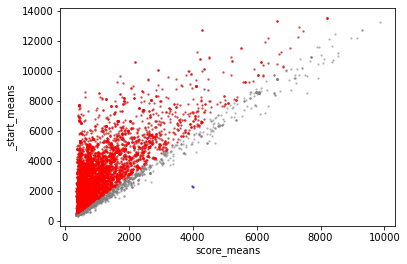

In [575]:
fig, ax = plt.subplots()
test["better_start"] = test["_start_means"] > 1.5 * test["score_means"]
test["worse_start"] = 1.5 * test["_start_means"] < test["score_means"]

test.plot.scatter(x = "score_means", y = "_start_means", c = "gray", alpha = 0.4, s = 2, ax = ax )
# test.query("good_start == True").plot.scatter(x = "score_means", y = "_start_means", c = "blue", alpha = 0.4, s = 2, ax = ax )
test.query("better_start == True").plot.scatter(x = "score_means", y = "_start_means", c = "red", alpha = 0.4, s = 2, ax = ax )
test.query("worse_start == True").plot.scatter(x = "score_means", y = "_start_means", c = "blue", alpha = 0.4, s = 2, ax = ax )

<AxesSubplot:xlabel='score_means', ylabel='_start_means'>

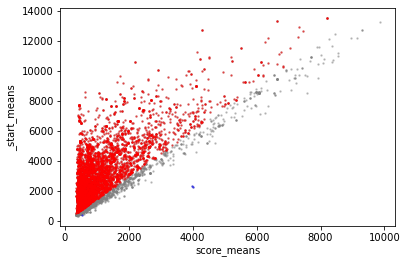

In [587]:
test["norm_score_means"] = test.score_means / test.length
test["norm_start_means"] = test._start_means / test.length
# sns.scatterplot(data = test, x = "norm_score_means", y = "norm_start_means", hue = "length")

test["norm_good_start"] = test.norm_start_means > 1.5 * test.norm_score_means
test["norm_bad_start"] = test.norm_start_means < 0.75 * test.norm_score_means

fig, ax = plt.subplots()

test.plot.scatter(x = "score_means", y = "_start_means", c = "gray", alpha = 0.4, s = 2, ax = ax )
# test.query("good_start == True").plot.scatter(x = "score_means", y = "_start_means", c = "blue", alpha = 0.4, s = 2, ax = ax )
test.query("norm_good_start == True").plot.scatter(x = "score_means", y = "_start_means", c = "red", alpha = 0.4, s = 2, ax = ax )
test.query("norm_bad_start == True").plot.scatter(x = "score_means", y = "_start_means", c = "blue", alpha = 0.4, s = 2, ax = ax )


In [593]:
tss["start_mean"] = tss["score"].apply(lambda x: np.mean(x[:buffer + buffer_into_transcript]))
tss["total_mean"] = tss["score"].apply(np.mean)
tss["good_start"] = tss["start_mean"] > 1.5 * tss["total_mean"]
tss["bad_start"] = tss["start_mean"] < 0.75 * tss["total_mean"]

tss

id  \
0       >transcript::chr22:12601786-12629425   
1      >transcript::chr4:142027532-142474934   
2        >transcript::chr8:96238923-96262110   
3          >transcript::chr4:1870960-1982707   
4          >transcript::chr4:1870960-1982707   
...                                      ...   
20792   >transcript::chr16:29899874-29906714   
20793    >transcript::KI270782.1:25859-45134   
20794       >transcript::chr16:189395-232455   
20795       >transcript::chr10:811305-932351   
20796       >transcript::chr16:190040-232455   

                                                     seq  length  \
0      GGCCCTTCACAAGCTTCACAGAGGTGGCTTCGGTCTTGAGCAAGGA...    1957   
1      AGCCCCCGGGCCTTGGAGATGAAGGCAGGCCCCTGCTCCACCCAGG...   48496   
2      CCCTCTCCCCGCCTTGCCGTCCGCCGCTGACGTAACCTGCGAAGTT...   34332   
3      CAAAGCCGGCGGCCCGCGGGCGCGCGCTCGGTCCGCCCCCGCGCCC...   40009   
4      CAAAGCCGGCGGCCCGCGGGCGCGCGCTCGGTCCGCCCCCGCGCCC...   40009   
...                                                  ...     ...   
20792  CTTGAGATTATCATCCGCTGAGGGTGGAAGCGGCCCCCGCAGACGC...   22310   
20793  GCCTGTCCTCAGAGAGCAGCGCCTCTTCCGACAGCCCCCATCCAGT...    1960   
20794  GGGAACAGCGACACGGGGGGAACAGCGACACGGGGGGAACAGCGAC...   45759   
20795  CTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAA...    1270   
20796  CACGGGGGGAACAGCGACACGGGGGGAACAGCGACACGGGGGGAAC...   45748   

                                                   score   transcript_id  \
0      [5873.0, 10774.0, 17171.0, 20978.0, 22919.0, 2...   MSTRG.23171.3   
1      [77.0, 230.0, 276.0, 414.0, 535.0, 682.0, 751....   MSTRG.26824.2   
2      [3329.0, 4963.0, 5736.0, 6169.0, 7690.0, 8515....   MSTRG.32655.3   
3      [216.0, 368.0, 637.0, 1101.0, 1918.0, 2637.0, ...  MSTRG.25862.10   
4      [216.0, 368.0, 637.0, 1101.0, 1918.0, 2637.0, ...   MSTRG.25862.7   
...                                                  ...             ...   
20792  [0.0, 0.0, 20.0, 20.0, 20.0, 42.0, 42.0, 107.0...   MSTRG.14691.2   
20793  [1058.0, 2042.0, 2955.0, 3514.0, 4105.0, 4664....    MSTRG.1506.1   
20794  [39.0, 59.0, 59.0, 59.0, 78.0, 121.0, 145.0, 1...  MSTRG.14032.21   
20795  [164.0, 339.0, 458.0, 655.0, 1069.0, 1228.0, 1...    MSTRG.6209.5   
20796  [0.0, 20.0, 62.0, 62.0, 83.0, 107.0, 146.0, 16...  MSTRG.14032.26   

       score_median  score_start    ranking  range_rank  good_start  \
0               0.0      20696.5        inf       107.5        True   
1              21.0       1190.5  56.690476      1349.5        True   
2             253.5      12063.5  47.587771      1726.5        True   
3             291.0      11776.0  40.467354      3617.0        True   
4             291.0      11776.0  40.467354      3617.0        True   
...             ...          ...        ...         ...         ...   
20792         514.0          0.0       -inf         NaN       False   
20793        5283.5          0.0       -inf         NaN       False   
20794         266.0          0.0       -inf         NaN       False   
20795        6639.0          0.0       -inf         NaN       False   
20796         266.0          0.0       -inf         NaN       False   

        start_mean   total_mean  bad_start  
0      9585.011667  3234.146142      False  
1      2581.490000   366.842688      False  
2      5058.781667   477.012554      False  
3      6567.195000   514.766877      False  
4      6567.195000   514.766877      False  
...            ...          ...        ...  
20792   604.150000   737.695294      False  
20793  1410.321667  5398.482653       True  
20794    24.005000   416.539260       True  
20795  3528.408333  8155.515748       True  
20796    33.218333   416.639416       True  

[20797 rows x 13 columns]

[None, None]

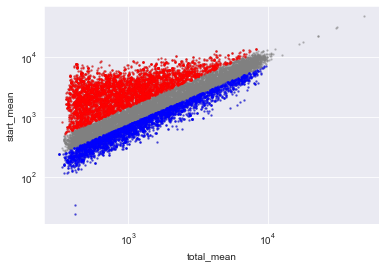

In [729]:

fig, ax = plt.subplots()

tss.plot.scatter(x = "total_mean", y = "start_mean", c = "gray", alpha = 0.4, s = 2, ax = ax )
# test.query("good_start == True").plot.scatter(x = "score_means", y = "_start_means", c = "blue", alpha = 0.4, s = 2, ax = ax )
tss.query("good_start == True").plot.scatter(x = "total_mean", y = "start_mean", c = "red", alpha = 0.4, s = 2, ax = ax )
tss.query("bad_start == True").plot.scatter(x = "total_mean", y = "start_mean", c = "blue", alpha = 0.4, s = 2, ax = ax )
# ax.set(xlim = (0, 15000), ylim = (0, 15000))

ax.set(xscale = "log", yscale = "log")

In [619]:
# ----------------------------------------------------------------
#   Apply log2(MedFC) to polyA
# ----------------------------------------------------------------
buffer_into_transcript = 100

polyA["score_median"] = polyA["score"].apply(np.mean)
polyA["score_start"] = polyA["score"].apply(lambda x: np.mean(x[len(x)-500-buffer_into_transcript-1:]))
polyA["ranking"] = polyA["score_start"] / polyA["score_median"]
polyA["ranking"] = polyA.ranking.apply(np.log2)

polyA[["id", "ranking"]].to_csv("polyA_rankings.csv", index = False)

In [620]:
polyA

id  \
0      >transcript::GL000008.2:150019-156694   
1        >transcript::GL000009.2:57805-62689   
2       >transcript::GL000009.2:82543-123125   
3       >transcript::GL000009.2:97670-125339   
4        >transcript::GL000194.1:61330-69574   
...                                      ...   
20315    >transcript::chrY:57206236-57212730   
20316    >transcript::chrY:57206238-57212730   
20317    >transcript::chrY:57206243-57212730   
20318    >transcript::chrY:57206980-57212730   
20319    >transcript::chrY:57206980-57210386   

                                                     seq  length  \
0      CATTGTCAGCTATCTTTATCACAGCCTGGCAATGTGGTAAAACAGA...    6675   
1      GGGGGGTCGGTTGAGCAGCAACCTGGTAAATTGTGGTCTTGTCAGT...    4884   
2      AAATCAGGTGTTACACTCCCAGTTTCGACAAAACGTATATACCAAT...   40582   
3      AATTGGTTGTAAATGTATATTGAGGAATTAGGTGTGTTCTTTGTTA...   27669   
4      GCAGGCCTGGGAATTCAGGTTCCTTTAGTTTCTTAAGAAACTACTA...    8244   
...                                                  ...     ...   
20315  TTTTATGGAGATGGGGTTTCACTATGTTGCCAGGGCTGGTCTCTAA...    2595   
20316  CAAGAGGAACGCCAGTGAGGAAGAGGTCCGGGGTGGGGCGCATAGG...    4123   
20317  AGCTGAAACGGATGTCTTCTTTGACTCATTCTCAAGCTAAATCTAC...    1370   
20318  GCTTGCAGGGAAGTGTGCAGGGAGAGGCATGAGTGGGAACTGGGGC...    1210   
20319  CAAAGAACAATCAGAACCACTCATCAGGGTGGCAATTCCCTTGGCA...    5677   

                                                   score   transcript_id  \
0      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       MSTRG.1.1   
1      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       MSTRG.2.1   
2      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       MSTRG.3.1   
3      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       MSTRG.3.2   
4      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       MSTRG.4.6   
...                                                  ...             ...   
20315  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   MSTRG.35756.6   
20316  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   MSTRG.35756.7   
20317  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   MSTRG.35756.8   
20318  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  MSTRG.35756.10   
20319  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  MSTRG.35756.11   

       score_median  score_start   ranking  
0          0.146816     0.066556 -1.141379  
1          0.204750     0.099834 -1.036267  
2          0.026613     0.000000      -inf  
3          0.039033     0.000000      -inf  
4          0.131004     0.000000      -inf  
...             ...          ...       ...  
20315      0.385356     0.565724  0.553904  
20316      0.242542     0.219634 -0.143133  
20317      0.729927     0.545757 -0.419493  
20318      0.651240     1.078203  0.727368  
20319      0.183195     0.099834 -0.875785  

[20320 rows x 8 columns]

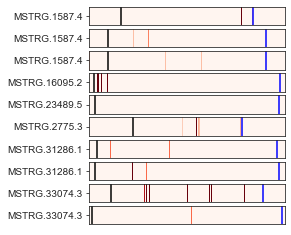

In [691]:
n = 10
offset = 0
fig, axs = plt.subplots(n, figsize =(3.5,4))

sns.set_style("ticks")

buffer = 500 # since we buffered symmetrically with 500bp
subset = polyA.query(f"transcript_id in {to_plot}").reset_index()
subset = subset.sort_values("transcript_id").reset_index()
for idx in range(n):
    i = idx + offset
    scores = subset["score"][i]
    id = subset["transcript_id"][i]
    grid = np.expand_dims(scores, 0)  
    i = idx  
    ax = axs[i]

    c = ax.pcolorfast(grid, cmap = "Reds")
    ax.set_yticks(np.arange(1) + 0.5 )
    ax.set_yticklabels([id],)
    ax.set_xticks([])
    ax.vlines(ymin = 0, ymax = 1, x = buffer, color = "black")
    ax.vlines(ymin = 0, ymax = 1, x = np.shape(grid)[1] - buffer, color = "blue")

fig.savefig("../Plots/polya_maps.jpg", dpi = 1000, bbox_inches = "tight")

final_subset = list(subset["transcript_id"])

# fig.colorbar(c)

In [629]:
polyA

id  \
0      >transcript::GL000008.2:150019-156694   
1        >transcript::GL000009.2:57805-62689   
2       >transcript::GL000009.2:82543-123125   
3       >transcript::GL000009.2:97670-125339   
4        >transcript::GL000194.1:61330-69574   
...                                      ...   
20315    >transcript::chrY:57206236-57212730   
20316    >transcript::chrY:57206238-57212730   
20317    >transcript::chrY:57206243-57212730   
20318    >transcript::chrY:57206980-57212730   
20319    >transcript::chrY:57206980-57210386   

                                                     seq  length  \
0      CATTGTCAGCTATCTTTATCACAGCCTGGCAATGTGGTAAAACAGA...    6675   
1      GGGGGGTCGGTTGAGCAGCAACCTGGTAAATTGTGGTCTTGTCAGT...    4884   
2      AAATCAGGTGTTACACTCCCAGTTTCGACAAAACGTATATACCAAT...   40582   
3      AATTGGTTGTAAATGTATATTGAGGAATTAGGTGTGTTCTTTGTTA...   27669   
4      GCAGGCCTGGGAATTCAGGTTCCTTTAGTTTCTTAAGAAACTACTA...    8244   
...                                                  ...     ...   
20315  TTTTATGGAGATGGGGTTTCACTATGTTGCCAGGGCTGGTCTCTAA...    2595   
20316  CAAGAGGAACGCCAGTGAGGAAGAGGTCCGGGGTGGGGCGCATAGG...    4123   
20317  AGCTGAAACGGATGTCTTCTTTGACTCATTCTCAAGCTAAATCTAC...    1370   
20318  GCTTGCAGGGAAGTGTGCAGGGAGAGGCATGAGTGGGAACTGGGGC...    1210   
20319  CAAAGAACAATCAGAACCACTCATCAGGGTGGCAATTCCCTTGGCA...    5677   

                                                   score   transcript_id  \
0      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       MSTRG.1.1   
1      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       MSTRG.2.1   
2      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       MSTRG.3.1   
3      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       MSTRG.3.2   
4      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       MSTRG.4.6   
...                                                  ...             ...   
20315  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   MSTRG.35756.6   
20316  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   MSTRG.35756.7   
20317  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   MSTRG.35756.8   
20318  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  MSTRG.35756.10   
20319  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  MSTRG.35756.11   

       score_median  score_start   ranking  
0          0.146816     0.066556 -1.141379  
1          0.204750     0.099834 -1.036267  
2          0.026613     0.000000      -inf  
3          0.039033     0.000000      -inf  
4          0.131004     0.000000      -inf  
...             ...          ...       ...  
20315      0.385356     0.565724  0.553904  
20316      0.242542     0.219634 -0.143133  
20317      0.729927     0.545757 -0.419493  
20318      0.651240     1.078203  0.727368  
20319      0.183195     0.099834 -0.875785  

[20320 rows x 8 columns]

In [635]:
polyA

id  \
0      >transcript::GL000008.2:150019-156694   
1        >transcript::GL000009.2:57805-62689   
2       >transcript::GL000009.2:82543-123125   
3       >transcript::GL000009.2:97670-125339   
4        >transcript::GL000194.1:61330-69574   
...                                      ...   
20315    >transcript::chrY:57206236-57212730   
20316    >transcript::chrY:57206238-57212730   
20317    >transcript::chrY:57206243-57212730   
20318    >transcript::chrY:57206980-57212730   
20319    >transcript::chrY:57206980-57210386   

                                                     seq  length  \
0      CATTGTCAGCTATCTTTATCACAGCCTGGCAATGTGGTAAAACAGA...    6675   
1      GGGGGGTCGGTTGAGCAGCAACCTGGTAAATTGTGGTCTTGTCAGT...    4884   
2      AAATCAGGTGTTACACTCCCAGTTTCGACAAAACGTATATACCAAT...   40582   
3      AATTGGTTGTAAATGTATATTGAGGAATTAGGTGTGTTCTTTGTTA...   27669   
4      GCAGGCCTGGGAATTCAGGTTCCTTTAGTTTCTTAAGAAACTACTA...    8244   
...                                                  ...     ...   
20315  TTTTATGGAGATGGGGTTTCACTATGTTGCCAGGGCTGGTCTCTAA...    2595   
20316  CAAGAGGAACGCCAGTGAGGAAGAGGTCCGGGGTGGGGCGCATAGG...    4123   
20317  AGCTGAAACGGATGTCTTCTTTGACTCATTCTCAAGCTAAATCTAC...    1370   
20318  GCTTGCAGGGAAGTGTGCAGGGAGAGGCATGAGTGGGAACTGGGGC...    1210   
20319  CAAAGAACAATCAGAACCACTCATCAGGGTGGCAATTCCCTTGGCA...    5677   

                                                   score   transcript_id  \
0      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       MSTRG.1.1   
1      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       MSTRG.2.1   
2      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       MSTRG.3.1   
3      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       MSTRG.3.2   
4      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       MSTRG.4.6   
...                                                  ...             ...   
20315  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   MSTRG.35756.6   
20316  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   MSTRG.35756.7   
20317  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   MSTRG.35756.8   
20318  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  MSTRG.35756.10   
20319  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  MSTRG.35756.11   

       score_median  score_start   ranking  good_start  bad_start  
0          0.146816     0.066556 -1.141379       False       True  
1          0.204750     0.099834 -1.036267       False       True  
2          0.026613     0.000000      -inf       False       True  
3          0.039033     0.000000      -inf       False       True  
4          0.131004     0.000000      -inf       False       True  
...             ...          ...       ...         ...        ...  
20315      0.385356     0.565724  0.553904       False      False  
20316      0.242542     0.219634 -0.143133       False      False  
20317      0.729927     0.545757 -0.419493       False       True  
20318      0.651240     1.078203  0.727368        True      False  
20319      0.183195     0.099834 -0.875785       False       True  

[20320 rows x 10 columns]

[None, None]

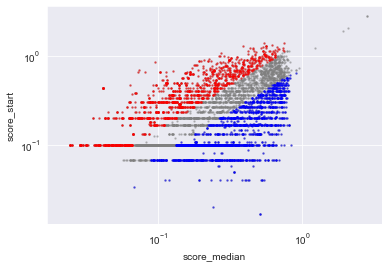

In [728]:
fig, ax = plt.subplots()
polyA["good_start"] = polyA["score_start"] > 1.5 * polyA["score_median"]
polyA["bad_start"] = polyA["score_start"] < 0.75 * polyA["score_median"]

polyA.plot.scatter(x = "score_median", y = "score_start", c = "gray", alpha = 0.4, s = 2, ax = ax )
# test.query("good_start == True").plot.scatter(x = "score_means", y = "_start_means", c = "blue", alpha = 0.4, s = 2, ax = ax )
polyA.query("good_start == True").plot.scatter(x = "score_median", y = "score_start", c = "red", alpha = 0.4, s = 2, ax = ax )
polyA.query("bad_start == True").plot.scatter(x = "score_median", y = "score_start", c = "blue", alpha = 0.4, s = 2, ax = ax )

ax.set(xscale = "log", yscale = "log")

In [726]:
tss.query("good_start == True")

id  \
0       >transcript::chr22:12601786-12629425   
1      >transcript::chr4:142027532-142474934   
2        >transcript::chr8:96238923-96262110   
3          >transcript::chr4:1870960-1982707   
4          >transcript::chr4:1870960-1982707   
...                                      ...   
18639     >transcript::chr12:9401925-9414068   
18729     >transcript::chr12:9396570-9400826   
18966    >transcript::chr2:41931099-41934629   
19063  >transcript::chr1:227730733-227735911   
19606  >transcript::chr1:227734948-227784835   

                                                     seq  length  \
0      GGCCCTTCACAAGCTTCACAGAGGTGGCTTCGGTCTTGAGCAAGGA...    1957   
1      AGCCCCCGGGCCTTGGAGATGAAGGCAGGCCCCTGCTCCACCCAGG...   48496   
2      CCCTCTCCCCGCCTTGCCGTCCGCCGCTGACGTAACCTGCGAAGTT...   34332   
3      CAAAGCCGGCGGCCCGCGGGCGCGCGCTCGGTCCGCCCCCGCGCCC...   40009   
4      CAAAGCCGGCGGCCCGCGGGCGCGCGCTCGGTCCGCCCCCGCGCCC...   40009   
...                                                  ...     ...   
18639  TTCAATAATTATTTGTTGAATAAATAAATGAAAAGAATTATGTGCC...   31440   
18729  AGCATTCAATAATTATTTGTTGAATAAATAAATGAAAAGAATTATG...   31444   
18966  GTTATCATTCGGTCATAATTAGCCTGACTGGTAAACCACAAGTGAA...   11061   
19063  TTTAAACTAATGGCTCTTTTAAAAAAGCATTGGAAATTAAGACATA...   12750   
19606  AGTATGATACAAATAAAAAATATTTTAAACTAATGGCTCTTTTAAA...   12773   

                                                   score   transcript_id  \
0      [5873.0, 10774.0, 17171.0, 20978.0, 22919.0, 2...   MSTRG.23171.3   
1      [77.0, 230.0, 276.0, 414.0, 535.0, 682.0, 751....   MSTRG.26824.2   
2      [3329.0, 4963.0, 5736.0, 6169.0, 7690.0, 8515....   MSTRG.32655.3   
3      [216.0, 368.0, 637.0, 1101.0, 1918.0, 2637.0, ...  MSTRG.25862.10   
4      [216.0, 368.0, 637.0, 1101.0, 1918.0, 2637.0, ...   MSTRG.25862.7   
...                                                  ...             ...   
18639  [46.0, 66.0, 133.0, 133.0, 153.0, 153.0, 175.0...    MSTRG.9399.6   
18729  [25.0, 25.0, 50.0, 83.0, 108.0, 128.0, 171.0, ...    MSTRG.9399.3   
18966  [20.0, 61.0, 61.0, 120.0, 156.0, 174.0, 192.0,...   MSTRG.20090.2   
19063  [46.0, 64.0, 64.0, 64.0, 110.0, 110.0, 128.0, ...    MSTRG.5978.3   
19606  [0.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0...   MSTRG.5977.26   

       score_median  score_start    ranking  range_rank  good_start  \
0               0.0      20696.5        inf       107.5        True   
1              21.0       1190.5  56.690476      1349.5        True   
2             253.5      12063.5  47.587771      1726.5        True   
3             291.0      11776.0  40.467354      3617.0        True   
4             291.0      11776.0  40.467354      3617.0        True   
...             ...          ...        ...         ...         ...   
18639         444.0        335.0  -0.406399         NaN        True   
18729         444.0        332.5  -0.417205         NaN        True   
18966         970.0        713.5  -0.443071         NaN        True   
19063         671.0        490.0  -0.453531         NaN        True   
19606         669.0        462.5  -0.532553         NaN        True   

        start_mean   total_mean  bad_start  
0      9585.011667  3234.146142      False  
1      2581.490000   366.842688      False  
2      5058.781667   477.012554      False  
3      6567.195000   514.766877      False  
4      6567.195000   514.766877      False  
...            ...          ...        ...  
18639   984.528333   617.034669      False  
18729   982.801667   616.977516      False  
18966  2122.411667  1413.049272      False  
19063  2364.661667  1189.230039      False  
19606  2178.160000  1187.197056      False  

[6286 rows x 13 columns]

<AxesSubplot:>

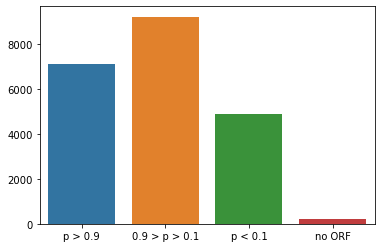

In [640]:
# also load the CPAT data to include in the figure
# read CPAT results
cpat_results = pd.read_table("../../data/CPAT/CPAT.ORF_prob.best.tsv")

upper_threshold = 0.9
lower_threshold = 0.1

labels = [
            f"p > {upper_threshold}", 
            f"{upper_threshold} > p > {lower_threshold}",
            f"p < {lower_threshold}",
]

prop_classification = lambda x: "0" if x > upper_threshold else ("1" if upper_threshold > x > lower_threshold else "2" )

cpat_results["label"] = cpat_results["Coding_prob"].apply(prop_classification)


fig, ax = plt.subplots()

# cpat_results.plot.scatter(x = "Fickett", y = "Coding_prob", ax = ax, alpha = cpat_results["Coding_prob"], c = "lightgray")
# sns.scatterplot(data = subset, x = "ID", y = "Coding_prob", hue = "ORF_strand", ax = ax, alpha = 0.5)
# subset.plot.scatter(x = "Fickett", y = "Coding_prob", ax = ax, c = "blue", alpha = 0.5)

# get number of transcripts without identifiyable ORF
with open("../../data/CPAT/CPAT.no_ORF.txt", "r") as f: 
    no_orfs = len(f.readlines())

# labels = sorted(list(set(cpat_results["label"])), key = lambda x: float(x[-1]), reverse = True)
counts = [len(cpat_results.query(f"label == '{i}'")) for i in range(len(labels))]

counts.append(no_orfs)
labels.append("no ORF")

novel_summary_df = pd.DataFrame(dict(
                                    label = labels, 
                                    count = counts,
                                ))

sns.barplot( 
            x = labels, 
            y = counts, 
            label = labels 
        )

# ax.set(xticks=[])

In [727]:
novel_summary_df

label  count
0        p > 0.9   7099
1  0.9 > p > 0.1   9219
2        p < 0.1   4874
3         no ORF    201

In [711]:


def add_subplot_label(idx, subplot, start_character, **kwargs):
    """
    Adds A B C ... to upper left corner of a subplot...
    """
    offset = kwargs.pop("offset", (0,0))
    fontsize = kwargs.pop("fontsize", 12)
    label = kwargs.pop("label", None)

    subplot_label = chr(ord(start_character)+idx) if label is None else label
    xoff, yoff = offset

    subplot.annotate(
                xy = (-0.1+xoff,1.03+yoff), 
                text = subplot_label, 
                xycoords = "axes fraction",
                weight = "bold", 
                fontsize = fontsize
            )
import matplotlib as mpl


/var/folders/1p/6pdz83894w5fnwm59tb6_3bh0000gp/T/ipykernel_57424/1157073346.py:27: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim = (0, 15000), ylim = (0, 15000))
/var/folders/1p/6pdz83894w5fnwm59tb6_3bh0000gp/T/ipykernel_57424/1157073346.py:27: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim = (0, 15000), ylim = (0, 15000))


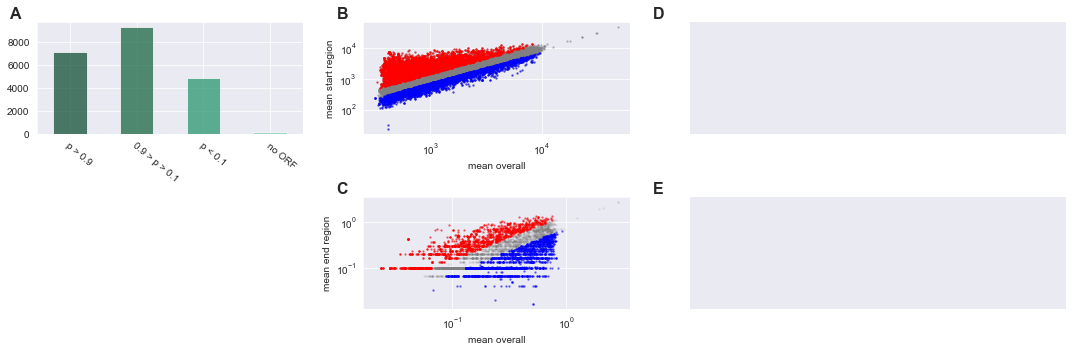

In [730]:
# =================================================================
#   Assemble a little figure for these ... 
# =================================================================

fig = plt.figure(figsize = (15, 5))

grid = fig.add_gridspec(2, 10)

# ax_mapped_reads = fig.add_subplot(grid[:, 0])
ax_cpat = fig.add_subplot(grid[0, :3])
ax_scatter_tss = fig.add_subplot(grid[0, 3:6])
ax_scatter_polya = fig.add_subplot(grid[1, 3:6])
ax_maps_tss = fig.add_subplot(grid[0, 6:])
ax_maps_polya = fig.add_subplot(grid[1, 6:])




# ----------------------------------------------------------------
# TSS Scatter
# ----------------------------------------------------------------

tss.plot.scatter(x = "total_mean", y = "start_mean", c = "gray", alpha = 0.4, s = 2, ax = ax_scatter_tss )
# test.query("good_start == True").plot.scatter(x = "score_means", y = "_start_means", c = "blue", alpha = 0.4, s = 2, ax = ax )
tss.query("good_start == True").plot.scatter(x = "total_mean", y = "start_mean", c = "red", alpha = 0.4, s = 2, ax = ax_scatter_tss )
tss.query("bad_start == True").plot.scatter(x = "total_mean", y = "start_mean", c = "blue", alpha = 0.4, s = 2, ax = ax_scatter_tss )
ax.set(xlim = (0, 15000), ylim = (0, 15000))

ax_scatter_tss.set(xlabel = "mean overall", ylabel = "mean start region", xscale = "log", yscale = "log")

# ----------------------------------------------------------------
# PolyA Scatter
# ----------------------------------------------------------------

polyA.plot.scatter(x = "score_median", y = "score_start", c = "gray", alpha = 0.1, s = 2, ax = ax_scatter_polya, style = 'seaborn-darkgrid' )
# test.query("good_start == True").plot.scatter(x = "score_means", y = "_start_means", c = "blue", alpha = 0.4, s = 2, ax = ax )
polyA.query("good_start == True").plot.scatter(x = "score_median", y = "score_start", c = "red", alpha = 0.4, s = 2, ax = ax_scatter_polya, style = 'seaborn-darkgrid' )
polyA.query("bad_start == True").plot.scatter(x = "score_median", y = "score_start", c = "blue", alpha = 0.4, s = 2, ax = ax_scatter_polya, style = 'seaborn-darkgrid' )

ax_scatter_polya.set(xlabel = "mean overall", ylabel = "mean end region", xscale = "log", yscale = "log")

# ----------------------------------------------------------------
#  CPAT
# ----------------------------------------------------------------

sns.set_style("darkgrid")

novel_summary_df.plot.bar( 
                            ax = ax_cpat,
                            x = "label", 
                            y = "count", 
                            color = ["xkcd:evergreen", "xkcd:spruce", "xkcd:viridian", "xkcd:pale teal"],
                            alpha = 0.7,
                        )
plt.setp( ax_cpat.xaxis.get_majorticklabels(), rotation=-40, ha="left", rotation_mode="anchor") 
ax_cpat.legend().remove()
ax_cpat.set(xlabel = "")
ax_cpat.axes.spines["left"].set_visible(True)

ax_cpat.axes.spines["bottom"].set_visible(True)

# ----------------------------------------------------------------
#  Maps (just loaded as images)
# ----------------------------------------------------------------

# ax_maps_tss.imshow(
#     plt.imread("../Plots/tss_maps.jpg")
# )

# ax_maps_polya.imshow(
#     plt.imread("../Plots/polya_maps.jpg")
# )

for i in [ax_maps_tss, ax_maps_polya]:
    i.set_xticks([])
    i.set_yticks([])
    i.axes.spines["left"].set_visible(False)
    i.axes.spines["right"].set_visible(False)
    i.axes.spines["top"].set_visible(False)
    i.axes.spines["bottom"].set_visible(False)

idx = 0
for i in [ax_cpat, ax_scatter_tss, ax_scatter_polya, ax_maps_tss, ax_maps_polya]:
    add_subplot_label(idx, i, "A", fontsize = 16)
    idx += 1

fig.savefig("../Plots/novels_stuff.svg")
plt.tight_layout(w_pad = 2)